# Logistic Regression, Softmax Regression, Data Loading


Epoch 1/10: Train Loss 0.6813, Val Acc 0.8081
Epoch 2/10: Train Loss 0.4868, Val Acc 0.9570
Epoch 3/10: Train Loss 0.3641, Val Acc 0.9814
Epoch 4/10: Train Loss 0.2711, Val Acc 0.9866
Epoch 5/10: Train Loss 0.2024, Val Acc 0.9878
Epoch 6/10: Train Loss 0.1542, Val Acc 0.9874
Epoch 7/10: Train Loss 0.1214, Val Acc 0.9866
Epoch 8/10: Train Loss 0.0991, Val Acc 0.9858
Epoch 9/10: Train Loss 0.0835, Val Acc 0.9862
Epoch 10/10: Train Loss 0.0721, Val Acc 0.9862

Binary Logistic Test Accuracy: 0.9967
Confusion Matrix:
 [[ 974    6]
 [   1 1134]]
Epoch 1/20: Val Acc 0.8935
Epoch 2/20: Val Acc 0.9062
Epoch 3/20: Val Acc 0.9127
Epoch 4/20: Val Acc 0.9157
Epoch 5/20: Val Acc 0.9168
Epoch 6/20: Val Acc 0.9189
Epoch 7/20: Val Acc 0.9213
Epoch 8/20: Val Acc 0.9214
Epoch 9/20: Val Acc 0.9220
Epoch 10/20: Val Acc 0.9223
Epoch 11/20: Val Acc 0.9238
Epoch 12/20: Val Acc 0.9239
Epoch 13/20: Val Acc 0.9240
Epoch 14/20: Val Acc 0.9237
Epoch 15/20: Val Acc 0.9241
Epoch 16/20: Val Acc 0.9243
Epoch 17/20: Va

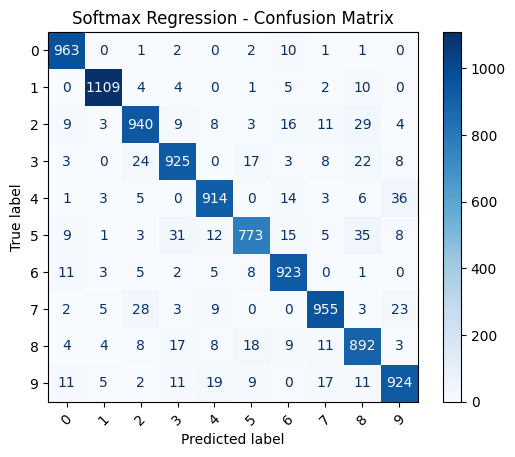

Overall Test Accuracy: 93.18%
Digit 0 Accuracy: 98.27%
Digit 1 Accuracy: 97.71%
Digit 2 Accuracy: 91.09%
Digit 3 Accuracy: 91.58%
Digit 4 Accuracy: 93.08%
Digit 5 Accuracy: 86.66%
Digit 6 Accuracy: 96.35%
Digit 7 Accuracy: 92.90%
Digit 8 Accuracy: 91.58%
Digit 9 Accuracy: 91.58%


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# =========================
# 1. Data Loading & Preprocessing
# =========================
def load_mnist_data(flatten=True):
    transform = transforms.ToTensor()
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # split train into train+val
    X_train, X_val, y_train, y_val = train_test_split(
        train_dataset.data.numpy(), train_dataset.targets.numpy(),
        test_size=0.2, stratify=train_dataset.targets.numpy(), random_state=42
    )

    if flatten:
        X_train = X_train.reshape(-1, 28*28)
        X_val   = X_val.reshape(-1, 28*28)
        X_test  = test_dataset.data.numpy().reshape(-1, 28*28)
    else:
        X_train = X_train[:, None, :, :]
        X_val   = X_val[:, None, :, :]
        X_test  = test_dataset.data.numpy()[:, None, :, :]

    # normalize once (0-1)
    X_train = torch.tensor(X_train, dtype=torch.float32)/255
    X_val   = torch.tensor(X_val, dtype=torch.float32)/255
    X_test  = torch.tensor(X_test, dtype=torch.float32)/255
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_val   = torch.tensor(y_val, dtype=torch.long)
    y_test  = torch.tensor(test_dataset.targets.numpy(), dtype=torch.long)

    train_tensor = TensorDataset(X_train, y_train)
    val_tensor   = TensorDataset(X_val, y_val)
    test_tensor  = TensorDataset(X_test, y_test)

    return train_tensor, val_tensor, test_tensor

# =========================
# 2. Models
# =========================
class LogisticRegressionBinary(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)

# =========================
# 3. Training Functions
# =========================
def train_binary_logistic(model, train_data, val_data, digit1=0, digit2=1, lr=0.01, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    def filter_data(dataset):
        X_list, y_list = [], []
        for X, y in DataLoader(dataset, batch_size=64):
            mask = (y==digit1)|(y==digit2)
            X_list.append(X[mask])
            y_list.append((y[mask]==digit2).float())
        return torch.cat(X_list).to(device), torch.cat(y_list).to(device)

    X_train, y_train = filter_data(train_data)
    X_val, y_val     = filter_data(val_data)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train).squeeze()
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # Val accuracy
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val).squeeze()
            val_acc = ((y_val_pred>0.5)==y_val).float().mean().item()
        print(f"Epoch {epoch+1}/{epochs}: Train Loss {loss.item():.4f}, Val Acc {val_acc:.4f}")

    # Test eval
    X_test, y_test = filter_data(test_linear)
    with torch.no_grad():
        y_test_pred = model(X_test).squeeze()
        test_acc = ((y_test_pred>0.5)==y_test).float().mean().item()
        cm = confusion_matrix(y_test.cpu(), (y_test_pred>0.5).long().cpu())
    print(f"\nBinary Logistic Test Accuracy: {test_acc:.4f}")
    print("Confusion Matrix:\n", cm)
    return test_acc, cm

def train_model(model, train_data, val_data, lr=0.001, epochs=20, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=batch_size)

    for epoch in range(epochs):
        # Train
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        # Val
        model.eval()
        correct, total = 0,0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                correct += (out.argmax(dim=1)==y).sum().item()
                total += y.size(0)
        val_acc = correct/total
        print(f"Epoch {epoch+1}/{epochs}: Val Acc {val_acc:.4f}")

    return model

# =========================
# 4. Load Data
# =========================
input_dim = 28*28
num_classes = 10

train_linear, val_linear, test_linear = load_mnist_data(flatten=True)
train_nn, val_nn, test_nn = load_mnist_data(flatten=False)

# =========================
# 5. Binary Logistic (0 vs 1)
# =========================
log_model = LogisticRegressionBinary(input_dim)
log_test_acc, log_cm = train_binary_logistic(log_model, train_linear, val_linear, digit1=0, digit2=1)

# =========================
# 6. Softmax Regression (10 classes)
# =========================
soft_model = SoftmaxRegression(input_dim, num_classes)
soft_model = train_model(soft_model, train_linear, val_linear, epochs=20)

# =========================
# 7. Test Softmax Regression
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
soft_model.to(device)
soft_model.eval()

X_test_tensor, y_test_tensor = test_linear.tensors
X_test_tensor = X_test_tensor.to(device)
with torch.no_grad():
    outputs = soft_model(X_test_tensor)
    preds = torch.argmax(outputs, dim=1)

cm = confusion_matrix(y_test_tensor.cpu(), preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Softmax Regression - Confusion Matrix")
plt.show()

overall_acc = accuracy_score(y_test_tensor.cpu(), preds.cpu())
print(f"Overall Test Accuracy: {overall_acc*100:.2f}%")
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"Digit {i} Accuracy: {acc*100:.2f}%")
